# Importação das Bibliotecas

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Funções Auxiliares

In [2]:
def display_image(image, title = "", size = 5):
    width, height = image.shape[0], image.shape[1]
    aspect_ratio = width/height
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

Função de pré-processamento apenas extrair o objeto principal binarizado.

In [3]:
def get_main_object(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (15, 15), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contourno_chave = contours[0]

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contourno_chave], 0, 255, -1)

    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (30, 30))
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return closing

# Funções Principais

Função principal, obtém a imagem binarizada contendo apenas o objeto de interesse e o seu respectivo contorno.

Retorna a **imagem alinhada** na horizontal, o seu **contorno**, o **ângulo de correção** e o modelo **PCA** ajustado.

In [4]:
def pca_image_alignment(image, contour):
    pts = contour.reshape(-1, 2)
    pca = PCA(n_components=2)
    pca.fit(pts)

    principal_component = pca.components_[0]
    angle_rad = np.arctan2(principal_component[1], principal_component[0])
    angle = np.degrees(angle_rad)

    if abs(angle) > 90:
        angle = angle - 180 if angle > 0 else angle + 180

    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    centroide = (cx, cy)

    (h, w) = image.shape[:2]

    alignment_matrix = cv2.getRotationMatrix2D(centroide, angle, 1.0)
    aligned_image = cv2.warpAffine(image, alignment_matrix, (w, h))
    
    aligned_contours, _ = cv2.findContours(aligned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    aligned_contour = max(aligned_contours, key=cv2.contourArea)

    return aligned_image, aligned_contour, angle, pca

Função opcional apenas pra visualização das componentes principais encontradas pelo modelo PCA.

Recebe a imagem binarizada e contorno da imagem a ser corrigida, o ângulo detectado desta imagem a ser corrigido e o modelo PCA treinado.

Retorna a preview da imagem a ser corrigida com as marcações, vetores das componentes principais e ângulo a ser corrigido.

In [5]:
def pca_image_preview(image, contour, angle, pca):
    image_preview = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(image_preview, [contour], 0, (0, 255, 0), 10)

    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    centroide = (cx, cy)

    variancias = pca.explained_variance_ratio_

    linha = 1000
    tam_linha1 = linha * variancias[0]
    tam_linha2 = linha * variancias[1]

    angle_rad = angle * np.pi / 180
    end_point1 = (int(cx + tam_linha1*np.cos(angle_rad)),int(cy + tam_linha1 * np.sin(angle_rad)))
    cv2.arrowedLine(image_preview, centroide, end_point1, (0, 0, 255), 5)

    end_point2 = (int(cx + tam_linha2 * np.cos(angle_rad + np.pi/2)),int(cy + tam_linha2 * np.sin(angle_rad + np.pi/2)))
    cv2.arrowedLine(image_preview, centroide, end_point2, (255, 0, 0), 5)

    cv2.putText(image_preview, f"Angulo: {-angle:.2f} graus", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 10)

    return image_preview

# Geração de imagem sintética

Carrega-se uma imagem qualquer, gera-se a imagem binarizada obtendo-se apenas o objeto principal e o seu respectivo contorno.

In [6]:
image = cv2.imread("../../../../imgs/chave1.jpg")
object = get_main_object(image)

## Ao invés de passar a nuvem de pontos de toda a imagem, passa apenas os pontos do contorno
contours, _ = cv2.findContours(object, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
object_contour = max(contours, key=cv2.contourArea)

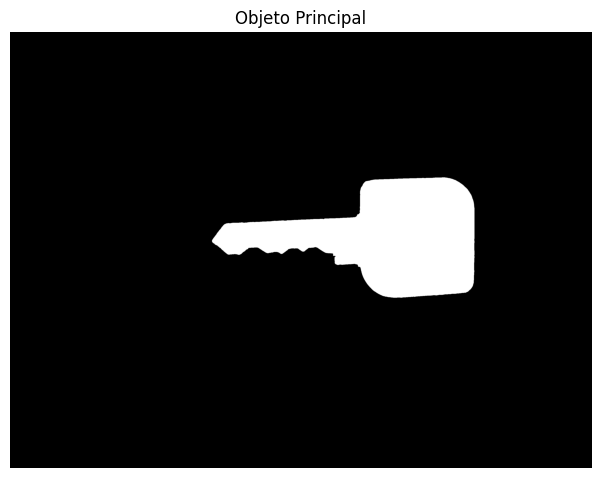

In [7]:
display_image(object, "Objeto Principal", 10)

Para a geração da imagem sintética rotaciona-se a imagem-objeto em um ângulo qualquer entre [-180, 180] para simular algum tipo de desalinhamento manual.

In [8]:
angle_sintetic = 45 #@param {type:"slider", min:-180, max:180, step:1}

(h, w) = object.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), angle_sintetic, 1.0)
rotated = cv2.warpAffine(object, M, (w, h))

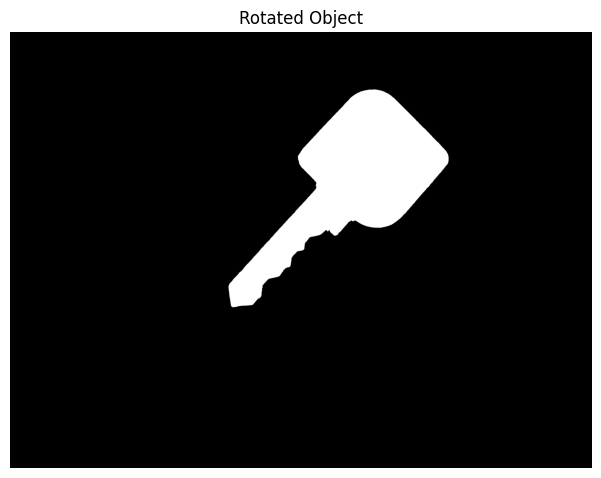

In [9]:
display_image(rotated, "Rotated Object", 10)

In [10]:
## Ao invés de passar a nuvem de pontos de toda a imagem, passa apenas os pontos do contorno
contours, _ = cv2.findContours(rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rotated_contour = max(contours, key=cv2.contourArea)

In [11]:
aligned_image, aligned_contour, angle, pca = pca_image_alignment(rotated, rotated_contour)
misaligned_pca_preview = pca_image_preview(rotated, rotated_contour, angle, pca)

In [12]:
_, _, angle, pca = pca_image_alignment(aligned_image, aligned_contour)
aligned_pca_preview = pca_image_preview(aligned_image, aligned_contour, angle, pca)

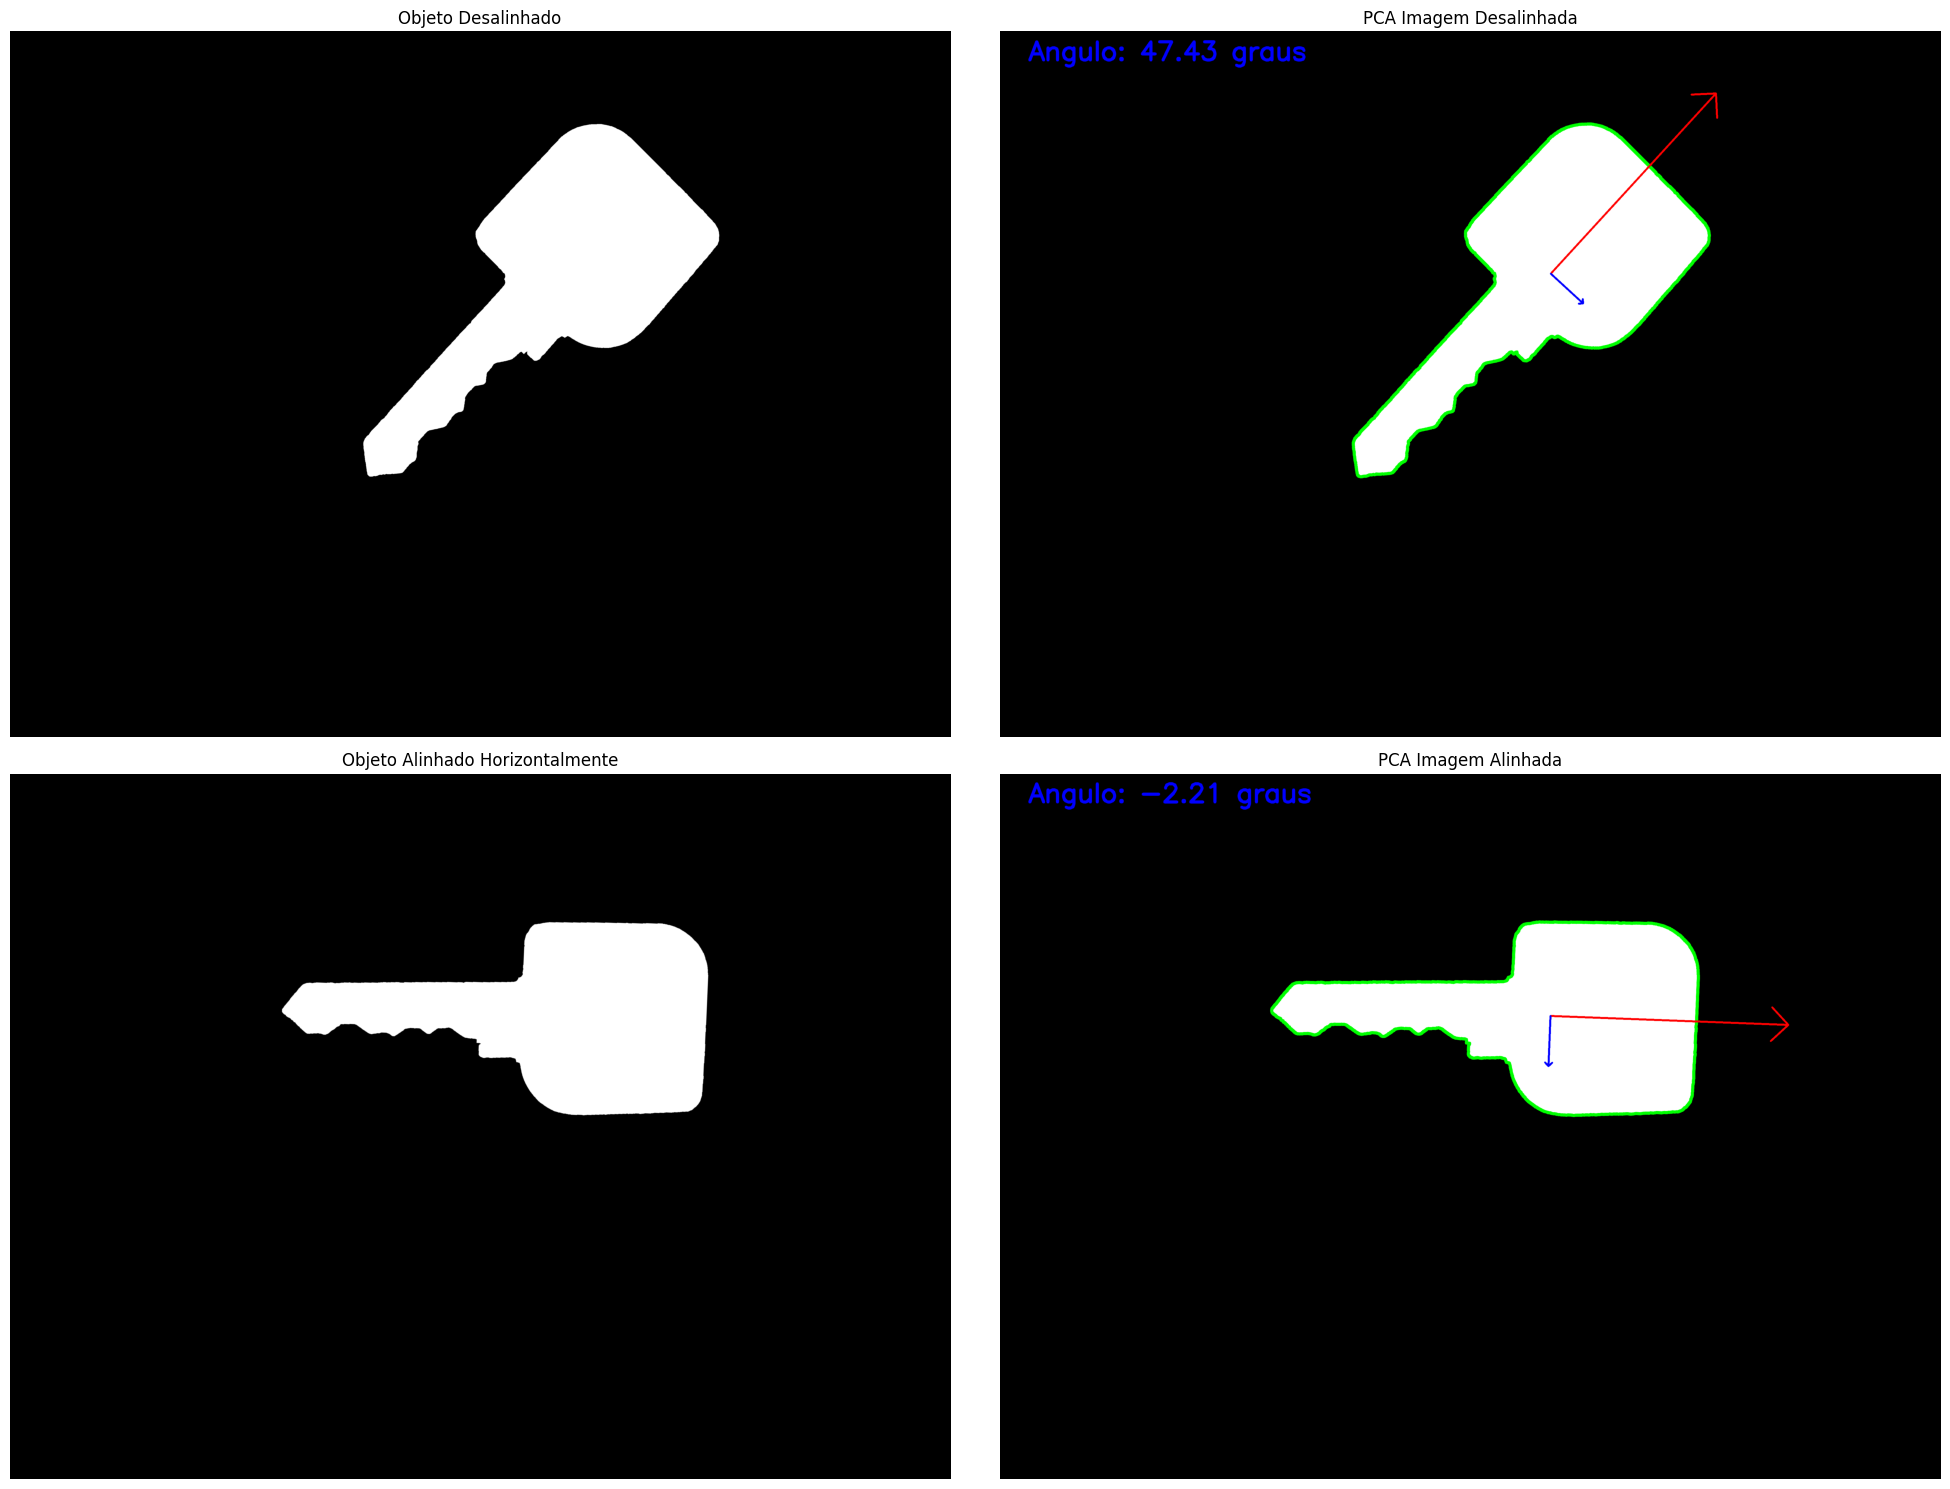

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes[0, 0].imshow(rotated, cmap='gray')
axes[0, 0].set_title("Objeto Desalinhado")
axes[0, 0].axis("off")
axes[0, 1].imshow(cv2.cvtColor(misaligned_pca_preview, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("PCA Imagem Desalinhada")
axes[0, 1].axis("off")

axes[1, 0].imshow(aligned_image, cmap='gray')
axes[1, 0].set_title("Objeto Alinhado Horizontalmente")
axes[1, 0].axis("off")
axes[1, 1].imshow(cv2.cvtColor(aligned_pca_preview, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("PCA Imagem Alinhada")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

# Referências

[Automatic Image Alignment Using Principal Component Analysis](https://ieeexplore.ieee.org/document/8540825)

[Detecting Orientation of Objects in Image using PCA and OpenCV](https://analyticsindiamag.com/ai-trends/detecting-orientation-of-objects-in-image-using-pca-and-opencv/)

[Aligning images using PCA](https://www.kaggle.com/code/darkrubiks/aligning-images-using-pca)